# CRGMS_analysis.ipynb
---

# Tutorial notebook for processing MCCE microstate file in ms_out folder. 

## Load the needed libraries and modules:

In [1]:
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys
import os

%matplotlib inline

# Module needed to read the microstate file:
import ms_analysis as msa
import weighted_correlation as wc

## Instantiate `msa.MSout` class with the desired MS file found in the ms_out output folder
### The most typical filename encountered is "pH7eH0ms.txt", meaning the MCCE simulation was a pH titation run at pH7.

In [2]:
msout_file = "ms_out/pH7eH0ms.txt"
mc = msa.MSout(msout_file)

print(f"Microstates count: {mc.N_ms:,}")
print(f"Unique microstates count: {mc.N_uniq:,}")

Microstates count: 5,700,000
Unique microstates count: 1,564,932


#### The following saves microstates attributes (energy, count and microstate state) into a list, which is then sorted by enthalpy, descendingly.

In [3]:
ms_orig_lst = [[ms.E, ms.count, ms.state] for  ms in list((mc.microstates.values()))]
ms_orig_lst = sorted(ms_orig_lst, key = lambda x:x[0])
print(ms_orig_lst[:2])

[[-679.297058, 6, [1, 14, 23, 34, 38, 45, 52, 69, 89, 95, 100, 105, 125, 126, 134, 141, 159, 175, 178, 252, 255, 261, 286, 287, 298, 308, 321, 323, 325, 345, 352, 357, 372, 406, 414, 416, 442, 451, 456, 459, 463, 475, 505, 508, 516, 531, 543, 548, 554, 562, 581, 600, 612, 630, 631, 641, 664, 680, 685, 699, 700, 729, 738, 743, 744, 773, 778, 783, 804, 841, 869, 877, 888, 911, 932, 940, 948, 950, 960, 966, 969, 973, 978, 1005, 1026, 1029, 1048, 1049, 1072, 1088, 1102, 1123, 1126, 1133, 1144, 1156, 1161, 1169, 1183, 1186, 1189, 1194, 1211, 1217, 1223, 1230, 1231, 1236, 1243, 1272, 1275, 1308, 1313, 1323, 1326, 1333, 1334, 1350, 1353, 1359, 1365, 1388, 1399, 1402, 1406, 1416, 1420, 1445, 1487, 1511, 1523, 1533, 1537, 1559, 1561, 1575, 1577, 1586, 1592, 1601, 1627, 1629, 1634, 1651, 1661, 1677, 1686, 1693, 1703, 1707, 1709, 1711, 1715, 1743, 1746, 1755, 1774, 1778, 1784, 1789, 1818, 1838, 1845, 1852, 1854, 1860, 1862, 1865, 1869, 1875, 1881, 1887, 1891, 1894, 1909, 1915, 1949, 1953, 1955, 1

### In MCCE, residues are divided into fixed or free residue groups.
 * Only free residues appear in the microstate sate list.
 * Fixed residues can be ionizable residues so we need to include their contribution to the total charge, which is called referred to here as __background charge__. 

#### Free residues information

In [4]:
free_residues = []
for res in mc.free_residues:
    free_residues.append(msa.conformers[res[0]].resid)
ms_free_residues = pd.DataFrame(free_residues,columns = ["Residue"])
print(f"Number of free residues: {ms_free_residues.shape[0]:,}")
ms_free_residues.head(3)
ms_free_residues.tail(3)

Number of free residues: 196


,Residue
193,ASNQ0097_
194,LYSQ0100_
195,CTRQ0100_


#### Fixed residues charge.
(Make sure to account for fixed residues charge for MD simulation protonation input.)

In [5]:
fixed_res_crg_dict = defaultdict(float)
for conf in msa.conformers:
    if conf.iconf in mc.fixed_iconfs:
        fixed_res_crg_dict[conf.resid] = conf.crg

background_charge = sum(fixed_res_crg_dict.values())
print("Background charge:", background_charge)

Background charge: 16.0


## Residues of interest
Note: Make sure to add the names of your residues of interest, such as quinone, here:

In [6]:
res_of_interest = ["ASP", "PL9", "GLU", "ARG", "HIS", "LYS", "TYR", "NTR", "CTR"]

### Save the fixed residues in your residues of interest to list:

In [7]:
fixed_res_of_interest = {k:v for k,v in fixed_res_crg_dict.items() if k[:3] in res_of_interest}

#fixed_residues_crg = pd.DataFrame.from_dict(fixed_res_of_interest, orient='index', columns=['Residue', 'crg'])
fixed_residues_crg = pd.DataFrame(fixed_res_of_interest.items(), columns=['Residue', 'crg'])

print(f"Number of fixed residues from residues of interest: {fixed_residues_crg.shape[0]:,}")
fixed_residues_crg

Number of fixed residues from residues of interest: 188


,Residue,crg
0,NTRF0002_,0.0
1,LYSF0003_,1.0
2,GLUF0005_,-1.0
3,ARGF0007_,1.0
4,GLUF0009_,-1.0
...,...,...
183,ARGQ0086_,1.0
184,ARGQ0088_,1.0
185,ASPQ0092_,-1.0
186,GLUQ0094_,-1.0


### This will convert the microstate conformer id to corresponding charge.

In [8]:
def convert_ms_crg(l, d):
    crg_lst =[[y[0], y[1], [convert_ms_crg(x, d) if isinstance(x, list) else d.get(x, x) for x in y[2]]] for y in l]
    
    return crg_lst

In [9]:
# Map conf index to conf charge:
id_vs_charge = {conf.iconf:conf.crg for conf in msa.conformers}

crg_orig_lst = convert_ms_crg(ms_orig_lst, id_vs_charge)
print(crg_orig_lst[:2])

[[-679.297058, 6, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, -1.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

## Function `findUniqueCrgmsCountOrder` will give the unique charge state id, corresponding count.

In [10]:
def findUniqueCrgmsCountOrder(crg_list_ms: list, begin_energy: float = None, end_energy: float = None):
    """You need to supply the charge list microstate here. Make sure
    the crg file is sorted with increasing order. If you want to filter 
    charge id based on the energy. Then you need to supply here.
    
    Variable unique_crg_state_order gives the order of unique charge state based on energy. 
    Lowest energy charge state will give the order 1 and then second unique charge 
    state will give the order 2. This order is based on unique charge ms order.
    
    Returns:
     A tuple of lists: all_crg_ms_unique, all_count, unique_crg_state_order, energy_diff_all
    """
    if not begin_energy and not end_energy:
        # no energy bounds given
        print("All energy microstates are selected.")
        begin_energy = crg_list_ms[0][0]
        end_energy = crg_list_ms[-1][0]
    elif begin_energy and end_energy:
        # both energy bounds given
        crg_list_ms = [[x[0], x[1], x[2]] for x in crg_list_ms if x[0] >= begin_energy and x[0] <= end_energy]   
    else:
        sys.exit("Both energy bounds are needed.")
        
    # unique charge as key and energy, count and order
    crg_all_count = {}
    unique_crg_state_order = 1
    for array in crg_list_ms:
        if tuple(array[2]) not in crg_all_count:
            crg_all_count[(tuple(array[2]))] = [array[1], [array[0]], [unique_crg_state_order]]
            unique_crg_state_order +=1
        else:
            crg_all_count[(tuple(array[2]))][0] += array[1]

            # add the maximum and minimum energy 
            min_energy = min(min(crg_all_count[(tuple(array[2]))][1]), array[0]) 
            max_energy = max(max(crg_all_count[(tuple(array[2]))][1]), array[0])

            # clear energy list and append minimum and maximum energy
            crg_all_count[(tuple(array[2]))][1].clear()
            crg_all_count[(tuple(array[2]))][1].append(min_energy)
            crg_all_count[(tuple(array[2]))][1].append(max_energy)

    # make a list of count, unique charge microstate, energy difference and order.
    all_crg_ms_unique  = []
    all_count = []
    energy_diff_all = []
    unique_crg_state_order = []
    for u, v in crg_all_count.items():
        all_crg_ms_unique.append(list(u))
        all_count.append(v[0])
        unique_crg_state_order.append(v[2][0])
        if len(v[1]) == 2:
            energy_diff_all.append(round(v[1][1]-v[1][0], 6))
        elif len(v[1]) == 1:
            energy_diff_all.append(0)
        else:
            sys.exit("Error while creating unique charge state: len(v[1]) is neither 1 or 2.")
    print(f"Number of charge ms: {len(crg_list_ms):,}")
    print(f"Number of unique charge ms: {len(all_crg_ms_unique)}")
    
    return all_crg_ms_unique, all_count, unique_crg_state_order, energy_diff_all 


def ConcaCrgMsPandas(unique_crg_ms_list, ms_count, ms_order, free_residues, background_charge, residue_interest_list):
    """
    """
    unique_crg_ms_list_pd = pd.DataFrame(unique_crg_ms_list).T
    ms_count_pd = pd.DataFrame(ms_count,columns = ["Count"]).T
    ms_order_pd = pd.DataFrame(ms_order,columns = ["Order"]).T
    crg_ms_count_pd = pd.concat([unique_crg_ms_list_pd, ms_count_pd, ms_order_pd])
    crg_count_res_1 = pd.concat([free_residues,crg_ms_count_pd], axis=1)
    crg_count_res_1.loc["Count", 'Residue'] = 'Count'
    crg_count_res_1.loc["Order", 'Residue'] = 'Order'
    all_crg_count_res = crg_count_res_1.set_index("Residue")
    
    # sort based on the count
    all_crg_count_res = all_crg_count_res.sort_values(by = "Count", axis = 1, ascending = False)
    all_crg_count_res.columns = range(all_crg_count_res.shape[1])
    all_crg_count_res = all_crg_count_res.T.set_index("Order")
    all_crg_count_res["Occupancy"] = round(all_crg_count_res["Count"]/ sum(all_crg_count_res["Count"]),3)
    all_crg_count_res['Sum_crg_protein'] =  all_crg_count_res.iloc[:, :-2].sum(axis = 1) + background_charge
    crg_count_res = all_crg_count_res.copy()
    for i in all_crg_count_res.columns:
        if i[:3] not in residue_interest_list and i != "Occupancy" and i != "Count" and i != "Sum_crg_protein":
            crg_count_res.drop([i], axis = 1, inplace = True)

    return crg_count_res

## Select all energy microstate list

In [11]:
charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst)

all_crg_count_res = ConcaCrgMsPandas(charge_ms_file[0],
                                     charge_ms_file[1],
                                     charge_ms_file[2], 
                                     ms_free_residues,
                                     background_charge,
                                     res_of_interest
                                    )
all_crg_count_res.head() 

All energy microstates are selected.
Number of charge ms: 1,564,932
Number of unique charge ms: 8552


/var/folders/x5/pfwlz84n7gx7cx3k91g6_jcw0000gn/T/ipykernel_1747/2886422385.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_crg_count_res["Occupancy"] = round(all_crg_count_res["Count"]/ sum(all_crg_count_res["Count"]),3)
/var/folders/x5/pfwlz84n7gx7cx3k91g6_jcw0000gn/T/ipykernel_1747/2886422385.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_crg_count_res['Sum_crg_protein'] =  all_crg_count_res.iloc[:, :-2].sum(axis = 1) + background_charge


Residue,PL9D0311_,HISF0018_,HISF0023_,ASPF0033_,GLUF0041_,TYRF0046_,HISF0048_,GLUF0056_,TYRF0066_,TYRF0072_,...,HISP0138_,GLUP0148_,NTRQ0001_,GLUQ0073_,ASPQ0089_,LYSQ0100_,CTRQ0100_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,,,,,,,,,,
3.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,645525.0,0.113,1.0
2.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,251547.0,0.044,0.0
1.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,228812.0,0.040,0.0
8.0,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,218984.0,0.038,2.0
15.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,204486.0,0.036,0.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Figure saved successfully: output/all_en_cr_ph7_vs_log(count).pdf


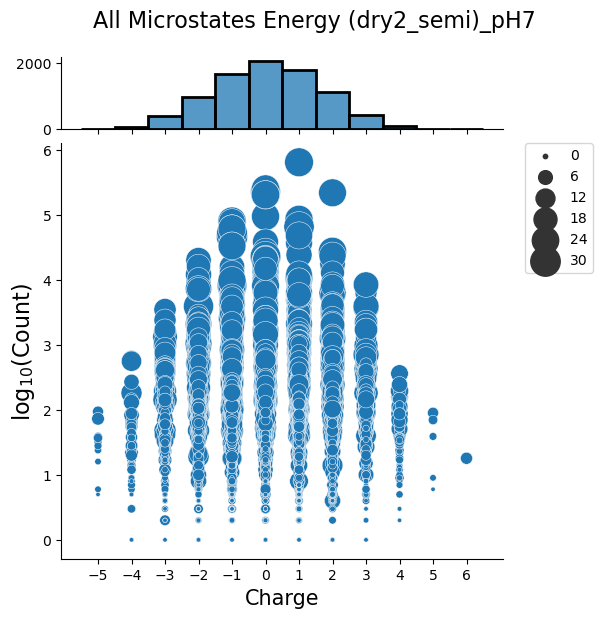

In [12]:
# Ensure 'output/' directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# Compute charge state population including background charge
x_av = [sum(x) + background_charge for x in charge_ms_file[0]]

# Avoid log(0) by replacing zeros with NaN (or a small positive value)
y_av = [math.log10(x) if x > 0 else float('nan') for x in charge_ms_file[1]]

# Convert energy differences to float
energy_diff_all_fl = [float(x) for x in charge_ms_file[3]]

# Initialize the JointGrid
g1 = sns.JointGrid(marginal_ticks=True, height=6)

# Scatter plot with bubble sizes based on energy differences
ax = sns.scatterplot(
    x=x_av, 
    y=y_av, 
    size=energy_diff_all_fl, 
    sizes=(10, 500), 
    ax=g1.ax_joint
)

# Set x-axis ticks based on the range of x_av
ax.set_xticks(range(int(min(x_av)), int(max(x_av)) + 1))

# Labels
ax.set_xlabel("Charge", fontsize=15)
ax.set_ylabel(r"log$_{10}$(Count)", fontsize=16)

# Adjust legend position
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Histogram on the marginal x-axis
ax2 = sns.histplot(
    x=x_av, 
    linewidth=2, 
    discrete=True, 
    ax=g1.ax_marg_x
)
ax2.set_ylabel(None)

# Remove y-axis marginal plot
g1.ax_marg_y.set_axis_off()

# Adjust layout and title
g1.fig.subplots_adjust(top=0.9)
g1.fig.suptitle("All Microstates Energy (dry2_semi)_pH7", fontsize=16)

# Save the figure
mc_energy_fig = os.path.join(output_dir, "all_en_cr_ph7_vs_log(count).pdf")
g1.savefig(mc_energy_fig, dpi=600, bbox_inches="tight")

print(f"Figure saved successfully: {mc_energy_fig}")

### This will plot the  tautomer charge distribution of unqiue charge microstate based on the occupancy. Each dot are unique charge microstate and color coded based on the energy difference of that microstate appear in Monte Carlo run. Total charge is sum of background and free charge (protein charge).

#### This is to get the unique charge microstate less or equal to  lowest energy + 1.36 KCal/Mol. Make sure your supply list is sorted based on energy in ascending (?) order. The order shows in dataframe is here within the selected energy range.

In [13]:
lowest_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst,
                                                  begin_energy = crg_orig_lst[0][0],
                                                  end_energy = crg_orig_lst[0][0] + 1.36
                                                 )
low_crg_count_res = ConcaCrgMsPandas(lowest_charge_ms_file[0],
                                     lowest_charge_ms_file[1],
                                     lowest_charge_ms_file[2], 
                                     ms_free_residues,
                                     background_charge,
                                     res_of_interest)
low_crg_count_res.head() 

Number of charge ms: 38
Number of unique charge ms: 4


/var/folders/x5/pfwlz84n7gx7cx3k91g6_jcw0000gn/T/ipykernel_1747/2886422385.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_crg_count_res["Occupancy"] = round(all_crg_count_res["Count"]/ sum(all_crg_count_res["Count"]),3)
/var/folders/x5/pfwlz84n7gx7cx3k91g6_jcw0000gn/T/ipykernel_1747/2886422385.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_crg_count_res['Sum_crg_protein'] =  all_crg_count_res.iloc[:, :-2].sum(axis = 1) + background_charge


Residue,PL9D0311_,HISF0018_,HISF0023_,ASPF0033_,GLUF0041_,TYRF0046_,HISF0048_,GLUF0056_,TYRF0066_,TYRF0072_,...,HISP0138_,GLUP0148_,NTRQ0001_,GLUQ0073_,ASPQ0089_,LYSQ0100_,CTRQ0100_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,78.0,0.510,0.0
3.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,53.0,0.346,1.0
2.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,17.0,0.111,0.0
4.0,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,5.0,0.033,1.0


#### This is to get the unique charge microstate around +/- 0.5 pH unit (+/- 0.68 Kcal/Mol) of average microstate energy. The order shows in dataframe is here within the selected energy range.

In [14]:
average_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst,
                                                   begin_energy = (mc.average_E - 0.68),
                                                   end_energy = (mc.average_E + 0.68)
                                                  )
av_crg_count_res = ConcaCrgMsPandas(average_charge_ms_file[0],
                                    average_charge_ms_file[1],
                                    average_charge_ms_file[2], 
                                    ms_free_residues,
                                    background_charge,
                                    res_of_interest
                                   )
av_crg_count_res.head() 

Number of charge ms: 208,463
Number of unique charge ms: 3410


/var/folders/x5/pfwlz84n7gx7cx3k91g6_jcw0000gn/T/ipykernel_1747/2886422385.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_crg_count_res["Occupancy"] = round(all_crg_count_res["Count"]/ sum(all_crg_count_res["Count"]),3)
/var/folders/x5/pfwlz84n7gx7cx3k91g6_jcw0000gn/T/ipykernel_1747/2886422385.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_crg_count_res['Sum_crg_protein'] =  all_crg_count_res.iloc[:, :-2].sum(axis = 1) + background_charge


Residue,PL9D0311_,HISF0018_,HISF0023_,ASPF0033_,GLUF0041_,TYRF0046_,HISF0048_,GLUF0056_,TYRF0066_,TYRF0072_,...,HISP0138_,GLUP0148_,NTRQ0001_,GLUQ0073_,ASPQ0089_,LYSQ0100_,CTRQ0100_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,,,,,,,,,,
4.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,73447.0,0.097,1.0
5.0,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,28624.0,0.038,2.0
9.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,28120.0,0.037,0.0
25.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,27932.0,0.037,0.0
6.0,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-1.0,1.0,-1.0,27372.0,0.036,0.0


### This is to get the unique charge microstate  of 1KT unit(1.36 Kcal/Mol) less or equal than highest energy state. The order shows in dataframe is here within the selected energy range.

In [15]:
highest_charge_ms_file = findUniqueCrgmsCountOrder(crg_orig_lst,
                                                   begin_energy = (mc.highest_E - 1.36),
                                                   end_energy = mc.highest_E
                                                  )
high_crg_count_res = ConcaCrgMsPandas(highest_charge_ms_file[0],
                                      highest_charge_ms_file[1],
                                      highest_charge_ms_file[2], 
                                      ms_free_residues,
                                      background_charge,
                                      res_of_interest)
high_crg_count_res.head()

Number of charge ms: 8
Number of unique charge ms: 2


/var/folders/x5/pfwlz84n7gx7cx3k91g6_jcw0000gn/T/ipykernel_1747/2886422385.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_crg_count_res["Occupancy"] = round(all_crg_count_res["Count"]/ sum(all_crg_count_res["Count"]),3)
/var/folders/x5/pfwlz84n7gx7cx3k91g6_jcw0000gn/T/ipykernel_1747/2886422385.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_crg_count_res['Sum_crg_protein'] =  all_crg_count_res.iloc[:, :-2].sum(axis = 1) + background_charge


Residue,PL9D0311_,HISF0018_,HISF0023_,ASPF0033_,GLUF0041_,TYRF0046_,HISF0048_,GLUF0056_,TYRF0066_,TYRF0072_,...,HISP0138_,GLUP0148_,NTRQ0001_,GLUQ0073_,ASPQ0089_,LYSQ0100_,CTRQ0100_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,27.0,0.844,2.0
2.0,0.0,1.0,1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,5.0,0.156,3.0


### Save all the dataframes.

In [16]:
# save all three data frames and non titrable residues charge information.
##writer = pd.ExcelWriter('charge_ms_dry2_semi_pH7.xlsx', engine='xlsxwriter')
##low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
##av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
##high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
##fixed_residues_crg.to_excel(writer, sheet_name = 'fixed_residues_crg')
##writer.save()

In [17]:
# Assuming you have already defined low_crg_count_res, av_crg_count_res, high_crg_count_res, and fixed_residues_crg
outfile_xl = "output/charge_ms_dry2_semi_pH7.xlsx"
try:
    # Create an ExcelWriter object
    writer = pd.ExcelWriter(outfile_xl, engine='xlsxwriter')

    # Write your dataframes to different sheets
    low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
    av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
    high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
    fixed_residues_crg.to_excel(writer, sheet_name='fixed_residues_crg')

    # Save the Excel file
    writer.save()
    print(f"Excel file {outfile_xl!s} saved successfully.")

except Exception as e:
    print(f"Error occurred while saving Excel file: {str(e)}")


# Save another DataFrame to a CSV file
# Due to column size issue in excel for large sytem. We save in csv format for all charge.   
crg_count_csv = "output/all_crg_count_res.csv"

try:
    all_crg_count_res.to_csv(crg_count_csv, header=True)
    print(f"CSV file {crg_count_csv!s} saved successfully.")

except Exception as e:
    print(f"Error occurred while saving CSV file: {str(e)}")


Error occurred while saving Excel file: 'XlsxWriter' object has no attribute 'save'
CSV file output/all_crg_count_res.csv saved successfully.


---
# Post-processing of already saved files to get the correlation matrix for residues. 

In [18]:
# This is for correlation.
all_crg_count_read = pd.read_csv(crg_count_csv, index_col = 0)
all_crg_count =  all_crg_count_read.iloc[:,:-2].T
all_crg_count

Order,3.0,2.0,1.0,8.0,15.0,10.0,7.0,11.0,4.0,6.0,...,5559.0,7969.0,6427.0,5080.0,1859.0,5504.0,8434.0,6241.0,5496.0,6909.0
PL9D0311_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HISF0018_,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
HISF0023_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ASPF0033_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
GLUF0041_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GLUQ0073_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ASPQ0089_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
LYSQ0100_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CTRQ0100_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [19]:
# drop if the protonation is not changing in free residues
all_crg_count["std"] = all_crg_count.std(axis=1).round(2)
all_crg_count_std = all_crg_count.loc[all_crg_count['std'] != 0].T[:-1].reset_index(drop=True)
all_crg_count_std

,HISF0018_,ASPF0033_,GLUF0041_,HISF0048_,GLUF0056_,TYRF0066_,TYRF0072_,ASPF0124_,GLUF0139_,ASPF0143_,...,NTRP0001_,LYSP0113_,ASPP0130_,HISP0138_,GLUP0148_,NTRQ0001_,ASPQ0089_,LYSQ0100_,CTRQ0100_,Count
0,0.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0,-1.0,645525.0
1,0.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0,-1.0,251547.0
2,0.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0,-1.0,228812.0
3,1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0,-1.0,218984.0
4,0.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0,-1.0,204486.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8547,1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,1.0,0.0,1.0,-1.0,1.0,-1.0,1.0
8548,1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,1.0,-1.0,1.0
8549,1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,1.0
8550,1.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,...,1.0,0.0,-1.0,1.0,0.0,1.0,-1.0,1.0,-1.0,1.0


In [20]:
all_crg_count_std.columns

Index(['HISF0018_', 'ASPF0033_', 'GLUF0041_', 'HISF0048_', 'GLUF0056_',
       'TYRF0066_', 'TYRF0072_', 'ASPF0124_', 'GLUF0139_', 'ASPF0143_',
       'GLUF0191_', 'GLUF0213_', 'GLUF0214_', 'HISF0239_', 'ASPF0245_',
       'ASPF0249_', 'GLUF0255_', 'GLUF0289_', 'LYSF0294_', 'LYSF0314_',
       'GLUF0326_', 'HISF0327_', 'ASPF0345_', 'ASPF0346_', 'CTRI0076_',
       'NTRN0005_', 'HISN0022_', 'LYSN0054_', 'GLUN0066_', 'TYRN0067_',
       'LYSN0086_', 'GLUN0173_', 'GLUN0194_', 'GLUN0197_', 'GLUN0226_',
       'GLUN0238_', 'GLUN0239_', 'GLUN0248_', 'GLUN0297_', 'NTRO0013_',
       'GLUO0020_', 'LYSO0046_', 'GLUO0061_', 'ASPO0085_', 'GLUO0108_',
       'LYSO0126_', 'NTRP0001_', 'LYSP0113_', 'ASPP0130_', 'HISP0138_',
       'GLUP0148_', 'NTRQ0001_', 'ASPQ0089_', 'LYSQ0100_', 'CTRQ0100_',
       'Count'],
      dtype='object')

In [21]:
# this is for demo: choose your favorite residues:

choose_res = ["GLUN0226_", "GLUN0173_", "ASPO0085_"]
def choose_res_data(df):
    df_choose_re= df.groupby(choose_res).Count.sum().reset_index()
    
    df_res_sort = df_choose_re.sort_values(by = "Count", ascending = False).reset_index(drop=True)
    return df_res_sort

In [22]:
df_choose_res_data = choose_res_data(all_crg_count_std)
df_choose_res_data

,GLUN0226_,GLUN0173_,ASPO0085_,Count
0,-1.0,0.0,-1.0,4950954.0
1,0.0,-1.0,-1.0,522342.0
2,-1.0,0.0,0.0,96232.0
3,0.0,0.0,-1.0,64548.0
4,0.0,-1.0,0.0,28800.0
5,-1.0,-1.0,0.0,18814.0
6,-1.0,-1.0,-1.0,18299.0
7,0.0,0.0,0.0,11.0


In [23]:
df_choose_res_data["Occupancy"] = round(df_choose_res_data["Count"]/sum(df_choose_res_data["Count"]), 2)

In [24]:
outfile = "output/cluster4_crg_count_res_june06_king.csv"
df_choose_res_data.to_csv(outfile, header=True)

In [25]:
def renameOrderResidues(file_input):
    rename_dict = {}
    acid_list = []
    base_list = []
    polar_rest_list = []
    ub_q_list = []
    non_residue_list = []

    for i in file_input.columns[:-1]:
        residue_number = i[4:8]
        if residue_number.isdigit():  # Check if the substring is numeric
            rename_dict[i] = i[3] + "_" + i[:3] + str(int(residue_number))
        else:
            rename_dict[i] = i[3] + "_" + i[:3] + residue_number

    rename_dict["Count"] = "Count"

    for x, y in rename_dict.items():
        if y[2:5] == 'ASP':
            rename_dict[x] = y[:1] + 'D' + y[5:]
            acid_list.append(y[:1] + 'D' + y[5:])
        if y[2:5] == 'GLU':
            rename_dict[x] = y[:1] + 'E' + y[5:]
            acid_list.append(y[:1] + 'E' + y[5:])
        if y[2:5] == 'ARG':
            rename_dict[x] = y[:1] + 'R' + y[5:]
            base_list.append(y[:1] + 'R' + y[5:])
        if y[2:5] == 'HIS':
            rename_dict[x] = y[:1] + 'H' + y[5:]
            base_list.append(y[:1] + 'H' + y[5:])
        if y[2:5] == 'LYS':
            rename_dict[x] = y[:1] + 'K' + y[5:]
            base_list.append(y[:1] + 'K' + y[5:])
        if y[2:5] == 'TYR':
            rename_dict[x] = y[:1] + 'Y' + y[5:]
            polar_rest_list.append(y[:1] + 'Y' + y[5:])
        if y[2:5] == 'CYS':
            rename_dict[x] = y[:1] + 'C' + y[5:]
            polar_rest_list.append(y[:1] + 'C' + y[5:])
        if y[2:5] == 'PL9':
            rename_dict[x] = 'MQ8' + y[5:]
            ub_q_list.append('MQ8' + y[5:])
        if y == "Count":
            non_residue_list.append(y)

    col_order_list = acid_list + polar_rest_list + base_list + ub_q_list + non_residue_list
    file_input = file_input.rename(rename_dict, axis=1)
    file_input = file_input[col_order_list]
    return file_input

In [26]:
df_chosen_res_renamed = renameOrderResidues(df_choose_res_data)
df_chosen_res_renamed

,NE226,NE173,OD85,Count
0,-1.0,0.0,-1.0,4950954.0
1,0.0,-1.0,-1.0,522342.0
2,-1.0,0.0,0.0,96232.0
3,0.0,0.0,-1.0,64548.0
4,0.0,-1.0,0.0,28800.0
5,-1.0,-1.0,0.0,18814.0
6,-1.0,-1.0,-1.0,18299.0
7,0.0,0.0,0.0,11.0


# Weighted correlation

In [27]:
df_correlation = wc.WeightedCorr(df=df_chosen_res_renamed, wcol="Count")(method="pearson")
df_correlation

,NE226,NE173,OD85
NE226,1.000000,-0.905880,0.047825
NE173,-0.905880,1.000000,-0.120476
OD85,0.047825,-0.120476,1.000000


In [28]:
def dropCorrCriterion(data_frame, cutoff=0.1):
    """
    # FIX: Does it work?
    Drop the residues if any of the correlation value is not greater than 0.1 except that residues.
    """
    if not cutoff:
        for i in data_frame.columns:
            if list(abs(data_frame[i]) >= cutoff).count(True) == 1:
                data_frame.drop(i, inplace=True)
                data_frame.drop(i, axis=1, inplace=True)

    return data_frame

In [29]:
df_corr_drop = dropCorrCriterion(df_correlation)
df_corr_drop

,NE226,NE173,OD85
NE226,1.000000,-0.905880,0.047825
NE173,-0.905880,1.000000,-0.120476
OD85,0.047825,-0.120476,1.000000


## Create a heatmap to display the residue correlation:

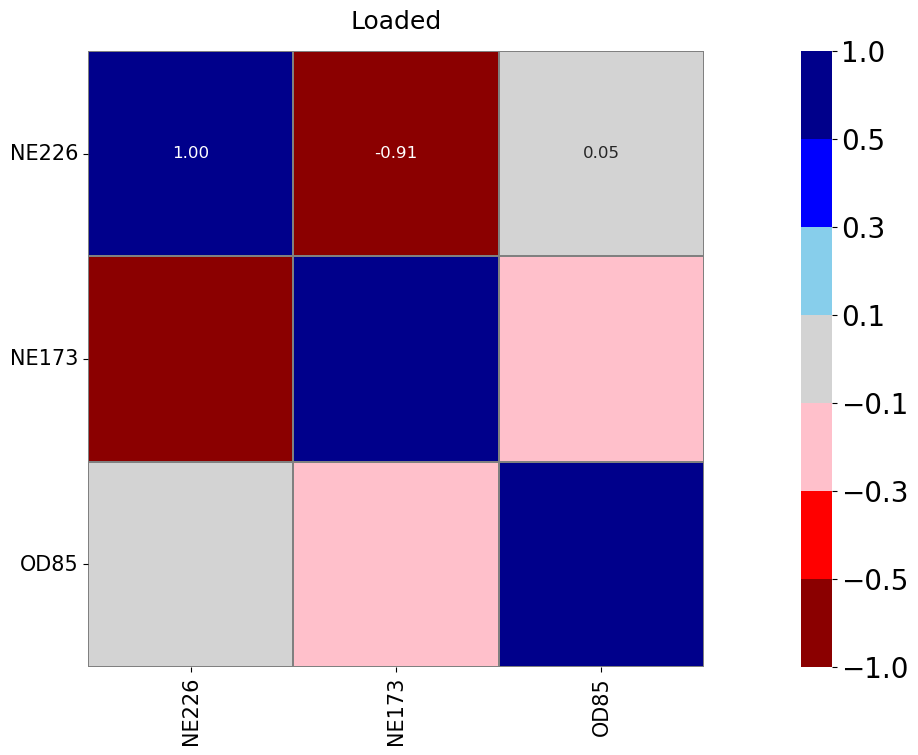

In [30]:
plt.figure(figsize=(25, 8))
cmap = ListedColormap(["darkred", "red", "pink", "lightgray","skyblue", "blue", "darkblue"])
bounds = [-1.0, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1.0]
norm = BoundaryNorm(bounds, cmap.N)
heatmap = sns.heatmap(df_correlation,
                      linecolor="gray",
                      cmap=cmap,
                      norm=norm,
                      square=True,
                      fmt=".2f",
                      linewidths=.01,
                      annot=True,
                      annot_kws={"fontsize":12}
                     )
heatmap.set_title("Loaded", fontdict={"fontsize":18}, pad=16)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.ylabel(None)
plt.xlabel(None)
plt.yticks(fontsize = 15, rotation = 0)
plt.xticks(fontsize = 15, rotation = 90)

corr_pdf = "output/corr.pdf"
plt.savefig(corr_pdf, dpi=600, bbox_inches="tight");